**[CDS-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
# Chapter03で最後に実行
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# jupyter notebook上にグラフを表示するために必要
%matplotlib inline

np.random.seed(20160704)
tf.set_random_seed(20160704)

**[CDS-02]** CIFAR-10 のデータセットをダウンロードします。ダウンロード完了まで少し時間がかかります。

In [2]:
%%bash
mkdir -p /tmp/cifar10_data
cd /tmp/cifar10_data
curl -OL http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
tar xzf cifar-10-binary.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  5740k      0  0:00:28  0:00:28 --:--:-- 5437k


**[CDS-03]** ダウンロードしたデータを確認します。ここでは、テストセット用のデータ test_batch.bin を使用します。

In [3]:
!ls -lR /tmp/cifar10_data

/tmp/cifar10_data:
total 166076
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 root root 170052171 Mar 17 08:41 cifar-10-binary.tar.gz

/tmp/cifar10_data/cifar-10-batches-bin:
total 180080
-rw-r--r-- 1 2156 1103       61 Jun  4  2009 batches.meta.txt
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 data_batch_1.bin
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 data_batch_2.bin
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 data_batch_3.bin
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 data_batch_4.bin
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 data_batch_5.bin
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 30730000 Jun  4  2009 test_batch.bin


**[CDS-04]** データファイルから画像イメージとラベルデータを読み取る関数を用意します。

In [4]:
def read_cifar10(filename_queue):
    class CIFAR10Record(object):
        pass
 
    result = CIFAR10Record()
    label_bytes = 1
    result.height = 32
    result.width = 32
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    record_bytes = label_bytes + image_bytes
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(filename_queue)
    record_bytes = tf.decode_raw(value, tf.uint8)
    result.label = tf.cast(
        tf.slice(record_bytes, [0], [label_bytes]), tf.int32)
    depth_major = tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),
                           [result.depth, result.height, result.width])
    # Convert from [depth, height, width] to [height, width, depth].
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])

    return result

**[CDS-04]** それぞれのラベルについて、8個ずつの画像イメージを表示します。

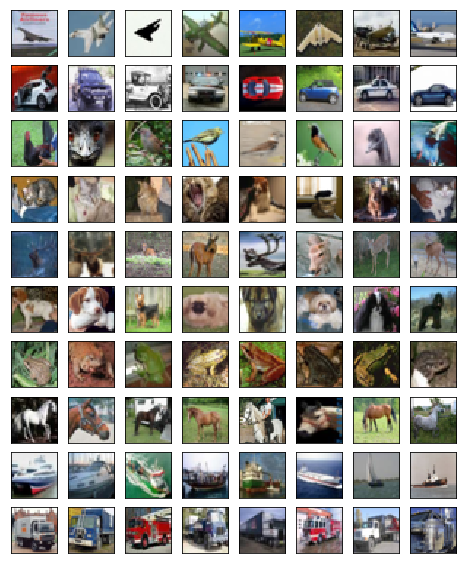

In [5]:
sess = tf.InteractiveSession()
filename = '/tmp/cifar10_data/cifar-10-batches-bin/test_batch.bin'
q = tf.FIFOQueue(99, [tf.string], shapes=())
q.enqueue([filename]).run(session=sess)
q.close().run(session=sess)
result = read_cifar10(q)

samples = [[] for l in range(10)]
while(True):
    label, image = sess.run([result.label, result.uint8image])
    label = label[0]
    if len(samples[label]) < 8:
        samples[label].append(image)
    if all([len(samples[l]) >= 8 for l in range(10)]):
        break
        
fig = plt.figure(figsize=(8,10))
for l in range(10):
    for c in range(8):
        subplot = fig.add_subplot(10, 8, l*8+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        image = samples[l][c]
        subplot.imshow(image.astype(np.uint8))
        
sess.close()

**[CDS-05]** 前処理を施した画像イメージを生成する関数を用意します。

In [6]:
def distorted_samples(image):

    reshaped_image = tf.cast(image, tf.float32)
    width, height = 24, 24
    float_images = []

    resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                           width, height)
    float_image = tf.image.per_image_standardization(resized_image)
    float_images.append(float_image)

    for _ in range(6):
        distorted_image = tf.random_crop(reshaped_image, [height, width, 3])
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image,
                                                     max_delta=63)
        distorted_image = tf.image.random_contrast(distorted_image,
                                                   lower=0.2, upper=1.8)
        float_image = tf.image.per_image_standardization(distorted_image)
        float_images.append(float_image)

    return tf.concat(0,float_images)

**[CDS-06]** それぞれのラベルについて、オリジナル、および、前処理を施した画像イメージを表示します。

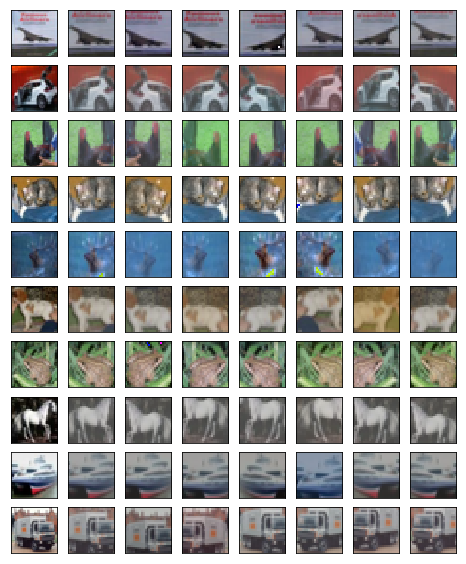

In [7]:
sess = tf.InteractiveSession()
filename = '/tmp/cifar10_data/cifar-10-batches-bin/test_batch.bin'
q = tf.FIFOQueue(99, [tf.string], shapes=())
q.enqueue([filename]).run(session=sess)
q.close().run(session=sess)
result = read_cifar10(q)

fig = plt.figure(figsize=(8,10))
c = 0
original = {}
modified = {}

while len(original.keys()) < 10:
    label, orig, dists = sess.run([result.label,
                                   result.uint8image,
                                   distorted_samples(result.uint8image)])
    label = label[0]
    if not label in original.keys():
        original[label] = orig
        modified[label] = dists

for l in range(10):
    orig, dists = original[l], modified[l]
    c += 1
    subplot = fig.add_subplot(10, 8, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(orig.astype(np.uint8))

    for i in range(7):
        c += 1
        subplot = fig.add_subplot(10, 8, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        pos = i*24
        image = dists[pos:pos+24]*40+120
        subplot.imshow(image.astype(np.uint8))
        
sess.close()